## Load dependencies

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# cd /content/drive/MyDrive/Training/UNet

In [1]:
import os

import torch 
import torch.nn as nn
from torch.optim import SGD, Adam, RMSprop
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, Subset

from PIL import Image, ImageOps
import matplotlib.pyplot as plt

from unet.Unet import *

/Users/muhammadwaseem/miniconda3/envs/torch/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/muhammadwaseem/miniconda3/envs/torch/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  Referenced from: <CAE66874-17C2-35C9-9C4D-6BA9770AF17F> /Users/muhammadwaseem/miniconda3/envs/torch/lib/python3.9/site-packages/torchvision/image.so
  Expected in:     <459875AA-DE2C-366B-9C44-90D4B3887080> /Users/muhammadwaseem/miniconda3/envs/torch/lib/python3.9/site-packages/torch/lib/libtorch_cpu.dylib
  warn(f"Failed to load image Python extension: {e}")


In [2]:
device = 'mps'

In [3]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
    #  576 choosen because, height and width would be even after 4 maxpooling
    transforms.Resize([576, 576]),
])

## Dataset preparation

In [4]:
class SegmentationDataset(Dataset):
    
    def __init__(self, imagePaths, maskPaths, transforms):

        self.imagefiles = os.listdir(imagePaths)
        self.maskfiles = os.listdir(maskPaths)
        
        if  '.DS_Store' in self.imagefiles:
            self.imagefiles.remove( '.DS_Store')
        if  '.DS_Store' in self.maskfiles:
            self.maskfiles.remove( '.DS_Store')
            
        self.imagefiles.sort()
        self.maskfiles.sort()
    
        for i in range(len(self.imagefiles)):
            self.imagefiles[i] = os.path.join(imagePaths,self.imagefiles[i])
            self.maskfiles[i] = os.path.join(maskPaths, self.maskfiles[i])
        
        self.transforms = transforms
        
    def __len__(self):
        return len(self.imagefiles)
    
    def __getitem__(self, idx):
        imagePath = self.imagefiles[idx]
        maskPath = self.maskfiles[idx]
        
        image =Image.open(imagePath)
        #m = Image.open(maskPath).convert('A')
        mask =Image.open(maskPath)
        mask = ImageOps.grayscale(mask)
        
        image = self.transforms(image)
        mask = self.transforms(mask)
        
        return (image, mask)

In [5]:
dataset = SegmentationDataset('data/imgs', 'data/masks', train_transform)

## Prepare Dataloader

In [6]:
torch.manual_seed(1)

total = len(dataset)
train_size = 0.75

train_total = int(train_size * total)
test_total = int((1-train_size )* total)

valid_total =  int((1-train_size) * train_total)
actual_train_total = int(train_size * train_total)


print(f'Train size: {actual_train_total} \nValidation Size: {valid_total} \nTest Size: {test_total}') 

Train size: 2862 
Validation Size: 954 
Test Size: 1272


In [7]:
randomised_idx = torch.randperm(total)

data_train = Subset(dataset, randomised_idx[:train_total])
data_test = Subset(dataset, randomised_idx[train_total: ])

data_train = Subset(dataset,randomised_idx[:actual_train_total])
data_valid = Subset(dataset, randomised_idx[actual_train_total: actual_train_total + valid_total])

In [8]:
len(data_train), len(data_valid), len(data_test)

(2862, 954, 1272)

In [9]:
data = DataLoader(data_train, batch_size=1, shuffle=True)
data_vl = DataLoader(data_valid, batch_size=1, shuffle=True)

In [10]:
next(iter(data))[0].shape

torch.Size([1, 3, 576, 576])

## Visualise data

In [11]:
import numpy as np

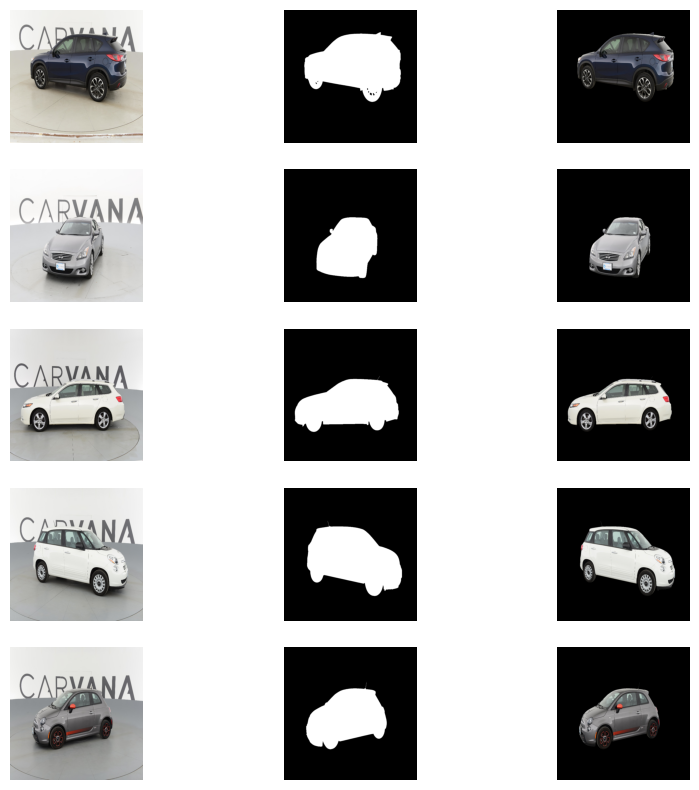

In [12]:
viz_data = DataLoader(data_train, 5, shuffle=False)

image_batch, mask_batch = next(iter(viz_data))
plt.figure(figsize=(10,10))

for i in range(1,16, 3):
    image_proper = (image_batch[i//3].permute(1,2,0))
    mask_proper = (mask_batch[i//3].permute(1,2,0))
    
    plt.subplot(5,3,i)
    plt.axis('off')
    plt.imshow(image_proper)
    
    plt.subplot(5,3,i+1)
    plt.axis('off')

    plt.imshow(mask_proper.squeeze(2), cmap='gray')
    
    plt.subplot(5,3,i+2)
    mask = mask_proper.permute(2,0,1)
    mask = transforms.ToPILImage()(mask)
    mask = transforms.Grayscale(num_output_channels=3)(mask)
    image_masked = transforms.functional.pil_to_tensor(mask) * image_proper.permute(2,0,1)

    image_masked = image_masked.numpy().transpose(1, 2, 0)
    plt.axis('off')
    plt.imshow(np.uint8(image_masked))
    

plt.show()

## Training step

In [13]:
model = UNet(3, 1)
model

UNet(
  (initial): InsideBlockConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): ContractionBlock(
    (contraction): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): InsideBlockConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm

In [15]:
optimizer = SGD(model.parameters(), lr=0.06, momentum=0.99)
loss_fn = nn.CrossEntropyLoss() if model.n_classes > 1 else nn.BCEWithLogitsLoss()


In [16]:
# def calculate_iou(pred_mask, true_mask):
#     intersection = (pred_mask & true_mask).float().sum((1, 2))  # sum over batch, height, and width dimensions
#     union = (pred_mask | true_mask).float().sum((1, 2))
#     iou = (intersection + 1e-6) / (union + 1e-6)  # add epsilon to avoid division by zero
#     return iou.mean()


In [17]:
def train(model, epoch, data, data_vl):
    train_loss = [0] * epoch
    train_accuracy = [0] * epoch
    validation_loss = [0] * epoch
    validation_accuracy = [0] * epoch
    for i in range(epoch):
        for x_batch, y_batch in data:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            train_loss[i] += (loss.item() * x_batch.size(0))
            # print("-----------------------------------------------------",calculate_iou(pred.cpu().to(torch.int8), y_batch.cpu().to(torch.int8)))
            # is_crt = ((pred>=0.5) == y_batch).sum().cpu()
            # train_accuracy[i] += is_crt.float()
        train_loss[i] /= len(data.dataset)
        # train_accuracy[i] /= len(data.dataset)
        print('Check1')
        with torch.no_grad():
            for x_batch, y_batch in data_vl:
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)
                pred = model(x_batch)
                loss = loss_fn(pred, y_batch)
                validation_loss[i] += (loss.item() * x_batch.size(0))
                # is_crt = ((pred>=0.5) == y_batch).sum().cpu()
                # validation_accuracy[i] += is_crt.float()
            validation_loss[i] /= len(data_vl.dataset)
            # validation_accuracy[i] /= len(data_vl.dataset)
        print(f'Epoch {i+1} loss: {train_loss[i]:.4f} val_loss:{validation_loss[i]:.4f}')
    return train_loss, train_accuracy, validation_loss, validation_accuracy

In [18]:
model = model.to(device)
epoch = 2
train_loss, train_accuracy, validation_loss, validation_accuracy = train(model, epoch, data, data_vl)

Check1
Epoch 1 loss: 0.0503 val_loss:0.0213
Check1
Epoch 2 loss: 0.0179 val_loss:0.0149


In [19]:
ls

LICENSE             Segmentation.ipynb  download.sh*        unet/
README.md           data/               images/


In [20]:
len(data_test)

1272

In [35]:
image , mask = data_test[120][0], data_test[120][1]
image = image.unsqueeze(0)
image = image.to(device)

pred = model(image).squeeze(0).cpu().detach()
image = image.squeeze(0).cpu()

In [36]:
pred.shape

torch.Size([1, 576, 576])

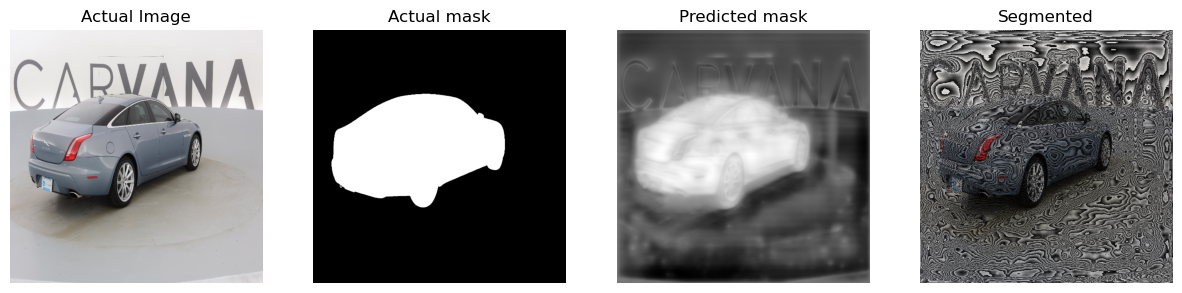

In [37]:
image_proper = (image.permute(1,2,0))
mask_proper = (mask.permute(1,2,0))
predicted_mask_proper = (pred.permute(1,2,0))

plt.figure(figsize=(15,35))
plt.tight_layout()
plt.subplot(5,4,i)
plt.title('Actual Image')
plt.axis('off')
plt.imshow(image_proper)

plt.subplot(5,4,i+1)
plt.title('Actual mask')
plt.axis('off')
plt.imshow(mask_proper.squeeze(2), cmap='gray')

plt.subplot(5,4,i+2)
plt.title('Predicted mask')
plt.axis('off')
plt.imshow(predicted_mask_proper.squeeze(2), cmap='gray')

plt.subplot(5,4,i+3)
plt.title('Segmented')
mask = predicted_mask_proper.permute(2,0,1)
mask = transforms.ToPILImage()(mask)
mask = transforms.Grayscale(num_output_channels=3)(mask)
image_masked = transforms.functional.pil_to_tensor(mask) * image_proper.permute(2,0,1)

image_masked = image_masked.numpy().transpose(1, 2, 0)
plt.axis('off')
plt.imshow(np.uint8(image_masked))

**Note**
- In just 2 epoch it outputs reasonably good mask. I am sticking to 2 epoch because of limited computing resource locally.
    - My free colab plan is exausted 🙃
- Will have to improve the training strategies, possibly divide the input image into large tiles and finally generate the output mask.S